In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
beaks_1975 = pd.read_csv('finch_beaks_1975.csv')
beaks_2012 = pd.read_csv('finch_beaks_2012.csv')
scandens_bd_heredity = pd.read_csv('scandens_beak_depth_heredity.csv')
fortis_bd_heredity = pd.read_csv('fortis_beak_depth_heredity.csv')

In [79]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

def pearson_r(x,y):
    corr = np.corrcoef(x,y)
    return corr[0,1]

def bs_replicate_1d(data, func):
    bs_sample = np.random.choice(data, size = len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    bs_replicate = np.empty(size)
    for i in range(size):
        bs_replicate[i] = bs_replicate_1d(data, func)
    return bs_replicate

def draw_bs_pair_linreg(x, y, size = 1):
    '''computing bootstrap replicate of slope an intercept of linear regression'''
    inds = np.arange(0,len(x))
    bs_slope_rep = np.empty(size)
    bs_intercept_rep = np.empty(size)
    
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        x_samp, y_samp = x[bs_inds], y[bs_inds]
        bs_slope_rep[i], bs_intercept_rep[i] = np.polyfit(x_samp, y_samp, 1)
        
    return bs_slope_rep, bs_intercept_rep

def draw_bs_rep_of_pair(x, y, func, size = 1):
    '''get boostrap replicate of a single statistic from pair of data'''
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        x_bs, y_bs = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(x_bs, y_bs)
    return bs_replicates

def heritability(parents, offsprings):
    '''compute the heritability from parents and offspring samples'''
    cov = np.cov(parents, offsprings)
    return cov[0,1]/cov[0,0]

We will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

First of all checking are there any changes in beak depth of scandens through plotting.

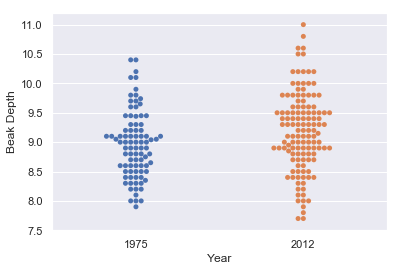

In [18]:
df = pd.concat([beaks_1975, beaks_2012])
df = df.loc[df['species'] == 'scandens', ]
_ = sns.swarmplot(x = 'year', y = 'bdepth', data = df)
_ = plt.xlabel('Year')
_ = plt.ylabel('Beak Depth')
plt.show()

It seems that the mean and variance of beak depth of scanden has increase in the year 2012 as compared to 1975

To confirm the above finding we can plot the ecdf of the above data

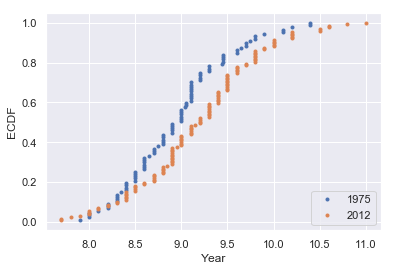

In [21]:
bd_1975 = df.loc[df['year'] == 1975, 'bdepth']
bd_2012 = df.loc[df['year'] == 2012, 'bdepth']
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

_ = plt.plot(x_1975, y_1975, marker = '.', linestyle = 'none')
_ = plt.plot(x_2012, y_2012, marker = '.', linestyle = 'none')
plt.legend(('1975', '2012'), loc = 'lower right')
_ = plt.xlabel('Year')
_ = plt.ylabel('ECDF')
plt.show()

So it is clear that in 2012 we had a higher mean and greater variance as compare to 1975

### Computing the difference of mean and its 95% confidence interval of beak depth

In [25]:
np.random.seed(42)
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)
bs_replicate_1975 = draw_bs_reps(bd_1975, np.mean, size = 10000)
bs_replicate_2012 = draw_bs_reps(bd_2012, np.mean, size = 10000)
bs_replicate_diff = bs_replicate_2012 - bs_replicate_1975
confiInterv = np.percentile(bs_replicate_diff, [2.5, 97.5])
print('The difference in beak depth of scanden between the year 2012 and 1975 is: ',mean_diff, 'mm and its confidence interval is :',confiInterv,'mm')

The difference in beak depth of scanden between the year 2012 and 1975 is:  0.22622047244094645 mm and its confidence interval is : [0.05633521 0.39190544] mm


### Hypothesis test: Are beaks deeper in 2012?
our plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?.</p>
Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. 

Assuming the null that there is no difference in beak depth from 1975 and 2012 and the difference of mean is zero, doing two sample bootstrap hypothesis testing.

In [32]:
np.random.seed(42)
observed_diff = np.mean(bd_2012) - np.mean(bd_1975)
#genreating the combined mean to shift the data
combined_mean = np.mean(np.concatenate((bd_2012, bd_1975)))
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean
#generating bootstrap replicate to calculate difference of mean
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, size = 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, size = 10000)
bs_replicates_diff = bs_replicates_2012 - bs_replicates_1975
#calculating the p-value
p = np.sum(bs_replicates_diff >= observed_diff)/len(bs_replicates_diff)
p

0.0034

We get a p-value of 0.0034 which suggests that there is a statistically significat difference.

# Variation of Beak Shapes
One possible explanation for increase in beak depth is because of the drough in year 1976/1977 which resulted in the death of small seed plants because of which only large seeds were left. Due to this reason only those birds survived and reproduce who had large beaks. So the question arises, did only beak depth increased or does the beak length increased too. If beak length also increased then overall shape of beak remain same it just got bigger, else if not then the shape of beak would be different. to check whether does the beak length also increase with beak depth we will do linear regression.


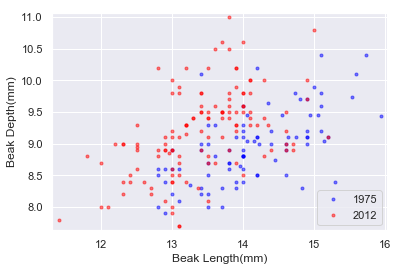

In [40]:
#First doing EDA
bl_1975 = df.loc[df['year'] == 1975, 'blength']
bl_2012 = df.loc[df['year'] == 2012, 'blength']

_ = plt.plot(bl_1975, bd_1975, marker = '.',linestyle = 'none', color = 'blue', alpha = 0.5)
_ = plt.plot(bl_2012, bd_2012, marker = '.',linestyle = 'none', color = 'red', alpha = 0.5)
plt.legend(('1975', '2012'), loc = 'lower right')
plt.margins(0.02)
_ = plt.xlabel('Beak Length(mm)')
_ = plt.ylabel('Beak Depth(mm)')
plt.show()

We can see that Beak length in 2012 is mostly less than 1975 which indicates that instead beak length might have gotten shorter.So it seems that the beak did not keep the same shape; they became shorter.

In [48]:
np.random.seed(42)
#Performing Linear regression
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

#Generating bootstrap sample for confidence interval
bs_slope_1975, bs_intercept_1975 = draw_bs_pair_linreg(bl_1975.values, bd_1975.values, size = 1000)
bs_slope_2012, bs_intercept_2012 = draw_bs_pair_linreg(bl_2012.values, bd_2012.values, size = 1000)

#Computing confidence intervals
ci_slope_1975 = np.percentile(bs_slope_1975, [2.5, 97.5])
ci_intercept_1975 = np.percentile(bs_intercept_1975, [2.5, 97.5])
ci_slope_2012 = np.percentile(bs_slope_2012, [2.5, 97.5])
ci_intercept_2012 = np.percentile(bs_intercept_2012, [2.5, 97.5])

print('Slope of 1975 with Confidence interval is:',slope_1975,ci_slope_1975)
print('Intercept of 1975 with Confidence interval is:',intercept_1975,ci_intercept_1975)
print('Slope of 2012 with Confidence interval is:',slope_2012,ci_slope_2012)
print('Intercept of 2012 with Confidence interval is:',intercept_2012,ci_intercept_2012)

Slope of 1975 with Confidence interval is: 0.4652051691605937 [0.33851226 0.59306491]
Intercept of 1975 with Confidence interval is: 2.3908752365842263 [0.64892945 4.18037063]
Slope of 2012 with Confidence interval is: 0.462630358835313 [0.33137479 0.60695527]
Intercept of 2012 with Confidence interval is: 2.9772474982360198 [1.06792753 4.70599387]


The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years but the intercept of 2012 was slightly higher suggesting that beak dept was little more. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [51]:
#Computing the length to depth ratio
ratio_1975 = np.array(bl_1975/bd_1975)
ratio_2012 = np.array(bl_2012/bd_2012)

#means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

#Computing bootstrap replicate to find confidence interval
bs_mean_ratio_1975 = draw_bs_reps(ratio_1975, np.mean, size = 10000)
bs_mean_ratio_2012 = draw_bs_reps(ratio_2012, np.mean, size = 10000)

#confidence intervals
ci_ratio_1975 = np.percentile(bs_mean_ratio_1975, [0.5, 99.5])
ci_ratio_2012 = np.percentile(bs_mean_ratio_2012, [0.5, 99.5])

print('for 1975, the ration of length to depth and confidence interval is:',mean_ratio_1975, ci_ratio_1975)
print('for 2012, the ration of length to depth and confidence interval is:',mean_ratio_2012, ci_ratio_2012)

for 1975, the ration of length to depth and confidence interval is: 1.5788823771858533 [1.55646491 1.60061626]
for 2012, the ration of length to depth and confidence interval is: 1.4658342276847767 [1.44424616 1.48894411]


From above we can see the length-to-depth ratio decreased by 0.1 and since there confidence interval also dont overlap so the change is real

## Heredity
The tendency of parental traits to be inherited by offspring.</p>
What is causing the beaks of Geospiza scandens to get bigger over time?</p>
The selective pressure brough on by the drought was mentioned above but why do some birds have such large beaks to begin with?.
<p>A prevailing explanation is that scanden birds are mating with the major finch species on Daphne Major, Geospiza fortis. These hybrid birds then mate with pure scandens in a process called introgressive hybridzation, which can bring fortis characterstics into the scandens species. In order to access the viability of this explanation, we need to know how strongly parental traits are passed on to offsprings, we will investigate the extent at which the parental beak depth is inherited by offspring in both scanden and fortis.</p>

In [63]:
bd_parent_scandens = scandens_bd_heredity['mid_parent'].values #contains average beak depth of parents
bd_offspring_scandens = scandens_bd_heredity['mid_offspring'].values

In [65]:
bd_offspring_fortis = fortis_bd_heredity['Mid-offspr'].values
bd_parent_fortis = (fortis_bd_heredity['Male BD'].values + fortis_bd_heredity['Female BD'].values)/2 #contain average beak depth of parent

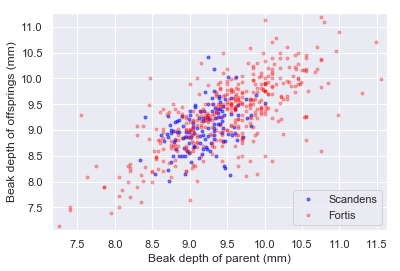

In [71]:
#Making scatter plots
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens, marker = '.', linestyle = 'none', color = 'blue', alpha = 0.5)
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis, marker = '.', linestyle = 'none', color = 'red', alpha = 0.3)
plt.legend(('Scandens', 'Fortis'), loc = 'lower right')
plt.margins(0.02)
_ = plt.xlabel('Beak depth of parent (mm)')
_ = plt.ylabel('Beak depth of offsprings (mm)')
plt.show()

It appears that there is a stronger relation in fortis than in scandens which mean that beak depth is most strongly inherited in fortis. We can further verify this by finding its correlation

In [78]:
np.random.seed(42)
#Computing the Pearson coefficient
coef_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
coef_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

#computing bootstrap replicate to generate confidence interval
coef_bs_scandens = draw_bs_rep_of_pair(bd_parent_scandens, bd_offspring_scandens, pearson_r, size = 1000)
coef_bs_fortis = draw_bs_rep_of_pair(bd_parent_fortis, bd_offspring_fortis, pearson_r, size = 1000)

#getting the confidence interval
ci_coef_scandens = np.percentile(coef_bs_scandens, [2.5, 97.5])
ci_coef_fortis = np.percentile(coef_bs_fortis, [2.5, 97.5])

print('The correlation and confidene interval between scandens is:',coef_scandens, ci_coef_scandens)
print('The correlation and confidene interval between fortis is:',coef_fortis, ci_coef_fortis)

The correlation and confidene interval between scandens is: 0.4117063629401258 [0.26564228 0.54388972]
The correlation and confidene interval between fortis is: 0.7283412395518487 [0.6694112  0.77840616]


Its clear that beak depth of fortis parent is more strongly correlated with their offsprings as compare to scandens

### Measuring heritability
the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. we will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

In [80]:
heritability_scanden = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis  = heritability(bd_parent_fortis, bd_offspring_fortis)

#Performing bootstrap to generate confidence interval
bs_herit_scanden = draw_bs_rep_of_pair(bd_parent_scandens, bd_offspring_scandens, heritability, size = 1000)
bs_herit_fortis = draw_bs_rep_of_pair(bd_parent_fortis, bd_offspring_fortis, heritability, size = 1000)

ci_herit_scanden = np.percentile(bs_herit_scanden, [2.5, 97.5])
ci_herit_fortis = np.percentile(bs_herit_fortis, [2.5, 97.5])

print('Heritability of Scanden:',heritability_scanden, ci_herit_scanden)
print('Heritability of Fortis:',heritability_fortis, ci_herit_fortis)

Heritability of Scanden: 0.5485340868685982 [0.35520904 0.75757246]
Heritability of Fortis: 0.7229051911438156 [0.65155209 0.79255002]


So we can see the heritability is strong in fortis

### Is beak depth heritable at all in G. scandens?
The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, we will do a pairs permutation test.

In [84]:
np.random.seed(42)
#Initiliazing an epmty array for replicates
perm_reps_herit = np.empty(1000)

for i in range(1000):
    perm_parent_scanden = np.random.permutation(bd_parent_scandens)
    perm_reps_herit[i] = heritability(perm_parent_scanden, bd_offspring_scandens)
    
p = np.sum(perm_reps_herit >= heritability_scanden)/len(perm_reps_herit)
p

0.0

Since the P-value we got is so small we will reject the null hypothesis and conclude that beak depth are indeed heritable by scandens.